<a href="https://colab.research.google.com/gist/ElanaPearl/444b3331f61485bbe8862db27cb2b968/mapping-chemical-space-with-umap.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright (c) 2021 Reverie Labs. All rights reserved. This work is licensed under the terms of the [MIT license](https://opensource.org/licenses/MIT).






# Imports & Utils

In [ ]:
%env PYTHONPATH=

env: PYTHONPATH=


In [ ]:
%%bash
# Install UMAP/hdbscan (recommend to do this before miniconda)
pip install --quiet umap-learn hdbscan

# Install miniconda
MINICONDA_INSTALLER_SCRIPT=Miniconda3-py37_4.9.2-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget -q https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX > /dev/null

# Install rdkit (should only be installed via conda)
conda install -y --quiet -c conda-forge rdkit=2020.09.2 > /dev/null

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.2/5.2 MB 64.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.3 MB/s eta 0:00:00


In [ ]:
import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

In [ ]:
import os
import time
from typing import List

import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from rdkit import Chem, DataStructs
from rdkit.Chem.rdchem import Mol
from rdkit.Chem.MolStandardize.rdMolStandardize import LargestFragmentChooser

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
import hdbscan

In [ ]:
# Silence non-critical RDKit warnings to minimize unnecessary outputs
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)

In [ ]:
# smiles로 부터 가장 큰 조각을 추출하는 함수
def get_largest_fragment_from_smiles(s: str):
    mol = Chem.MolFromSmiles(s)
    if mol:
        clean_mol = LargestFragmentChooser().choose(mol)
        return Chem.MolToSmiles(clean_mol)
    return None

# ecfp를 계산하는 함수
def compute_ecfp_descriptors(smiles_list: List[str]):
    """ Computes ecfp descriptors """
    
    keep_idx = []
    descriptors = []
    for i, smiles in enumerate(smiles_list):
        ecfp = _compute_single_ecfp_descriptor(smiles)
        if ecfp is not None:
            keep_idx.append(i)
            descriptors.append(ecfp)

    return np.vstack(descriptors), keep_idx

def _compute_single_ecfp_descriptor(smiles: str):
    try:
        mol = Chem.MolFromSmiles(smiles)
    except Exception as E:
        return None

    if mol:
        fp = Chem.AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        return np.array(fp)
    
    return None

In [ ]:
from inspect import getmembers, isfunction
print(getmembers(Chem.AllChem.GetMorganFingerprintAsBitVect, isfunction))

[]


In [ ]:
def plot_global_embeddings_with_clusters(df: pd.DataFrame,
                          x_col: str,
                          y_col: str,
                          cluster_col: str,
                          title: str = "",
                          x_lim = None,
                          y_lim = None):
    """ Plots data colored by soft HDBSCAN clusters
    
    If the cluster of a compund is not specified (cluster < 0), it will be
    plotted gray, otherwise it will be colored by the cluster value.
    """
    clustered = df[cluster_col].values >= 0
    
    plt.figure(figsize=(10,8))
    ax=sns.scatterplot(data=df.iloc[~clustered],
                    x=x_col,
                    y=y_col,
                    color=(0.5, 0.5, 0.5),
                    s=10,
                    alpha=0.1)
    sns.scatterplot(data=df.iloc[clustered],
                    x=x_col,
                    y=y_col,
                    hue=cluster_col,
                    alpha=0.5,
                    palette="nipy_spectral",
                    ax=ax)
    if x_lim:
      ax.set_xlim(x_lim)
    if y_lim:
      ax.set_ylim(y_lim)

    sm = plt.cm.ScalarMappable(cmap="nipy_spectral")
    sm.set_array([])
    ax.get_legend().remove()
    ax.figure.colorbar(sm, label="Global Cluster")
  
    plt.title(title)
    plt.show()

# Embed Pre-Training Dataset, Pre-Training Results, Fine-Tuning Dataset, and Fine-Tuning Results with UMAP, PCA, t-SNE (Dataset-Specific Embeddings)

### Read in and process data

In [ ]:
#Modification


bbbp_Pre_Dataset = pd.read_csv("./Dataset/reference.txt", sep = "\t", header = None)
bbbp_Pre = pd.read_csv("./Dataset/Transformer_Encoder_FFNN_ref10.csv", header = None)
bbbp_Fine_Dataset = pd.read_csv("./Dataset/latent_covid.csv", header = None)
bbbp_Fine = pd.read_csv("./Dataset/Transformer_FINETUNING_filtered.csv", header = None)



bbbp_Pre_Dataset.columns = ["smiles"]
bbbp_Pre.columns = ["smiles"]

bbbp_Fine_Dataset.columns = ["smiles"]
bbbp_Fine.columns = ["smiles"]


bbbp_Pre = pd.DataFrame(bbbp_Pre.loc[0:10000, "smiles"])


FileNotFoundError: ignored

In [ ]:
bbbp_Pre_Dataset.head()

NameError: ignored

In [ ]:
bbbp_Pre_Dataset = bbbp_Pre_Dataset.sample(1000, random_state = 1004)

bbbp_Pre_Dataset

NameError: ignored

In [ ]:
bbbp_Pre = bbbp_Pre.sample(1000, random_state = 1004)
bbbp_Pre

,smiles
448,C=C(Br)C(=O)NCCCC(N)=O
5483,O=S(=O)(NCc1ccccc1)c1cccc2nsnc12
4064,Cc1ccc(C(=O)N2CCC(Cc3ccccc3)CC2)cc1S(=O)(=O)Nc...
3314,O=c1[nH]nc2n1CCc1ccc(-c3cccnc3)cc1-2
5006,CC(C)C1OC1CCCCCCCCCCCC(N)CNC1CC1
...,...
5934,CCN(c1ccccc1)S(=O)(=O)c1ccc(Br)s1
897,N=C1C2CC3CC(C2)CC1(c1ccc(-c2ccccc2)cc1)C3
4655,O=C(c1ccco1)N1CCC(c2nc(O)c3oc4ccccc4c3n2)CC1
4520,COC(=O)CSc1nc2c(c(=O)n1-c1ccccc1)SCC2


In [ ]:
bbbp_Fine

,smiles
0,SMILES
1,Nc1[CH]ncc1-c1ccc(C2=NS(=O)(=O)c3c(O)c(Cl)ccc3...
2,c1(C)c2c(C(NC(OC)=O)C(O)=O)c(cccc2)c(NC(=O)N)c1
3,FC(F)(F)c1cccc(CN2C[C@@H](C)C(=O)C2)c1NC(=O)C(...
4,OC(Cc1ccc2c(c1)N(C(=O)CO)CC2)C(Cc1ccccc1)=O
...,...
1085,C1CCCCC1N(Cc1c(C2CCC2)cc(CC2CC2)nc1)c1ccccc1
1086,C1C(C2=C(C(=O)NC)C3(CCCCC3)CCC2(C)CN)C=C1
1087,O=C(NC(C(F)(F)F)C(F)(F)F)CCC(=O)N1CCNCC1
1088,s1c(-c2c(N3CCC5CCCCC5(C)C3)cccc2)ccc1Cl


In [ ]:


bbbp_Pre_Dataset["Transfer_Learning"] = "Pre-Training_Dataset"
bbbp_Pre_Dataset["Index"] = bbbp_Pre_Dataset.index.values

bbbp_Pre["Transfer_Learning"] = "Pre-Training"
bbbp_Pre["Index"] = bbbp_Pre.index.values

bbbp_Fine_Dataset["Transfer_Learning"] = "Fine-Tuning_Dataset"
bbbp_Fine_Dataset["Index"] = bbbp_Fine_Dataset.index.values

bbbp_Fine["Transfer_Learning"] = "Fine-Tuning"
bbbp_Fine["Index"] = bbbp_Fine.index.values

In [ ]:
Concat_Pre_Fine = pd.concat([bbbp_Pre_Dataset, bbbp_Pre, bbbp_Fine_Dataset, bbbp_Fine], axis = 0)

Concat_Pre_Fine

,smiles,Transfer_Learning,Index
216545,CCCCNCCN1CN(c2ccccc2)C2(CCN(C3CCCc4ccc(Cl)cc43...,Pre-Training_Dataset,216545
459680,CC(CNc1ccc(OC(F)(F)F)cc1)NC(=O)C(CCC1CCCCC1)CC...,Pre-Training_Dataset,459680
922067,Cc1cc(C)c(N)c(Cl)c1,Pre-Training_Dataset,922067
718630,CCc1nc2c(C)cc(C)nc2n1Cc1ccc(-c2ccccc2S(=O)(=O)...,Pre-Training_Dataset,718630
74999,O=c1sc2cc(N(S(=O)(=O)c3ccccc3)S(=O)(=O)c3ccccc...,Pre-Training_Dataset,74999
...,...,...,...
1085,C1CCCCC1N(Cc1c(C2CCC2)cc(CC2CC2)nc1)c1ccccc1,Fine-Tuning,1085
1086,C1C(C2=C(C(=O)NC)C3(CCCCC3)CCC2(C)CN)C=C1,Fine-Tuning,1086
1087,O=C(NC(C(F)(F)F)C(F)(F)F)CCC(=O)N1CCNCC1,Fine-Tuning,1087
1088,s1c(-c2c(N3CCC5CCCCC5(C)C3)cccc2)ccc1Cl,Fine-Tuning,1088


### Compute ECFP Descriptors

In [ ]:
bbbp = Concat_Pre_Fine


In [ ]:
hue_parameter = "Transfer_Learning"

In [ ]:
# Compute desrciptors and keep track of which failed to featurize
ecfp_descriptors, keep_idx = compute_ecfp_descriptors(bbbp["smiles"])

# Only keep those that sucessfully featurized
bbbp = bbbp.iloc[keep_idx]

### Embed with UMAP

In [ ]:
%%time
umap_model = umap.UMAP(metric = "jaccard",
                      n_neighbors = 25,
                      n_components = 2,
                      low_memory = False,
                      min_dist = 0.001)
X_umap = umap_model.fit_transform(ecfp_descriptors)
bbbp["UMAP_1"], bbbp["UMAP_2"] = X_umap[:,0], X_umap[:,1]

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 1min 1s, sys: 350 ms, total: 1min 1s
Wall time: 1min 5s


<timed exec>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Embed with PCA

In [ ]:
%%time
pca = PCA(n_components=2)
X_pca = pca.fit_transform(ecfp_descriptors)
bbbp["PCA_1"], bbbp["PCA_2"] = X_pca[:,0], X_pca[:,1]

CPU times: user 771 ms, sys: 558 ms, total: 1.33 s
Wall time: 722 ms


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Embed with t-SNE

In [ ]:
%%time
tsne = TSNE(n_components=2)
X_tsne = tsne.fit_transform(ecfp_descriptors)
bbbp["TNSE_1"], bbbp["TNSE_2"] = X_tsne[:,0], X_tsne[:,1]

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


CPU times: user 1min 14s, sys: 477 ms, total: 1min 15s
Wall time: 55.2 s


<timed exec>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
#bbbp.to_csv('/content/gdrive/MyDrive/추가 자료/딥러닝을 이용한 신약개발/논문 작성/리뷰어 코멘트/Fine_Tuning Dataset Visualization UMAP/Results/Pre-Training_Fine-Tuning.csv', index = False)

### Visualize the dataset embeddedings

In [ ]:
palette = []
palette.extend(sns.color_palette("Blues", 2))
palette.extend(sns.color_palette("BuGn", 2))

palette

[(0.6718954248366014, 0.8143790849673203, 0.9006535947712418),
 (0.21568627450980393, 0.5294117647058824, 0.7542483660130719),
 (0.6666666666666667, 0.873202614379085, 0.8261437908496732),
 (0.21568627450980393, 0.6366013071895424, 0.39869281045751637)]

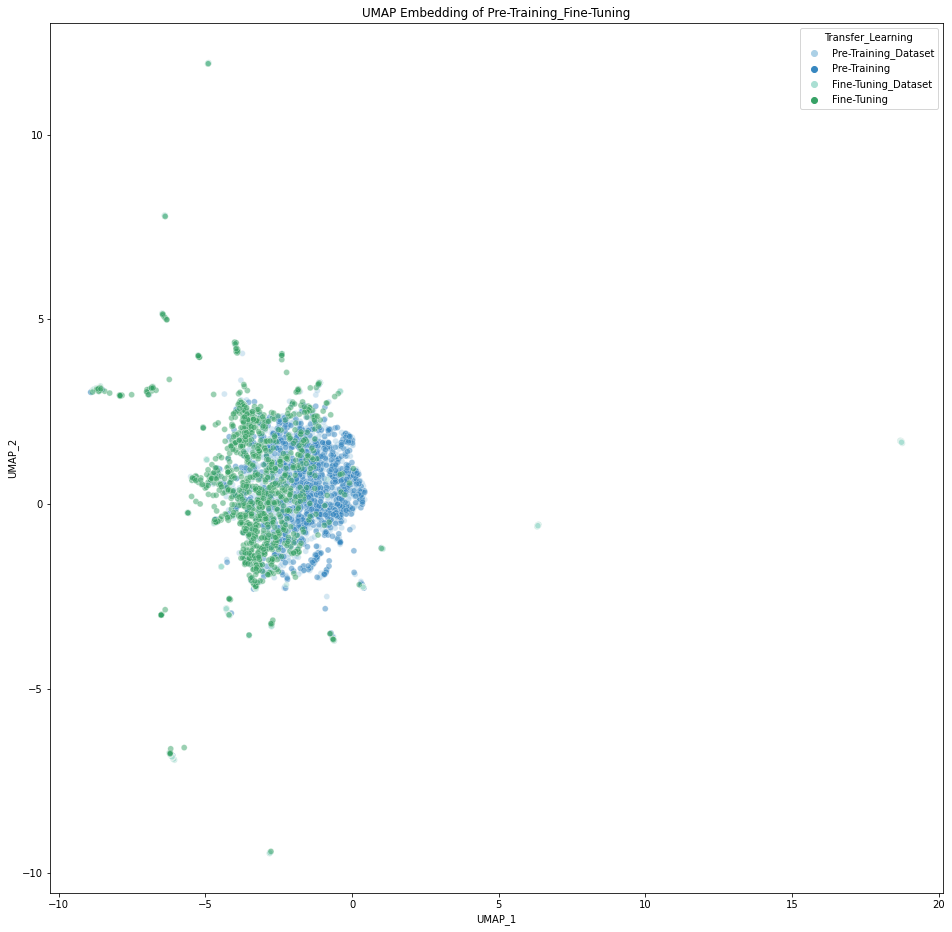

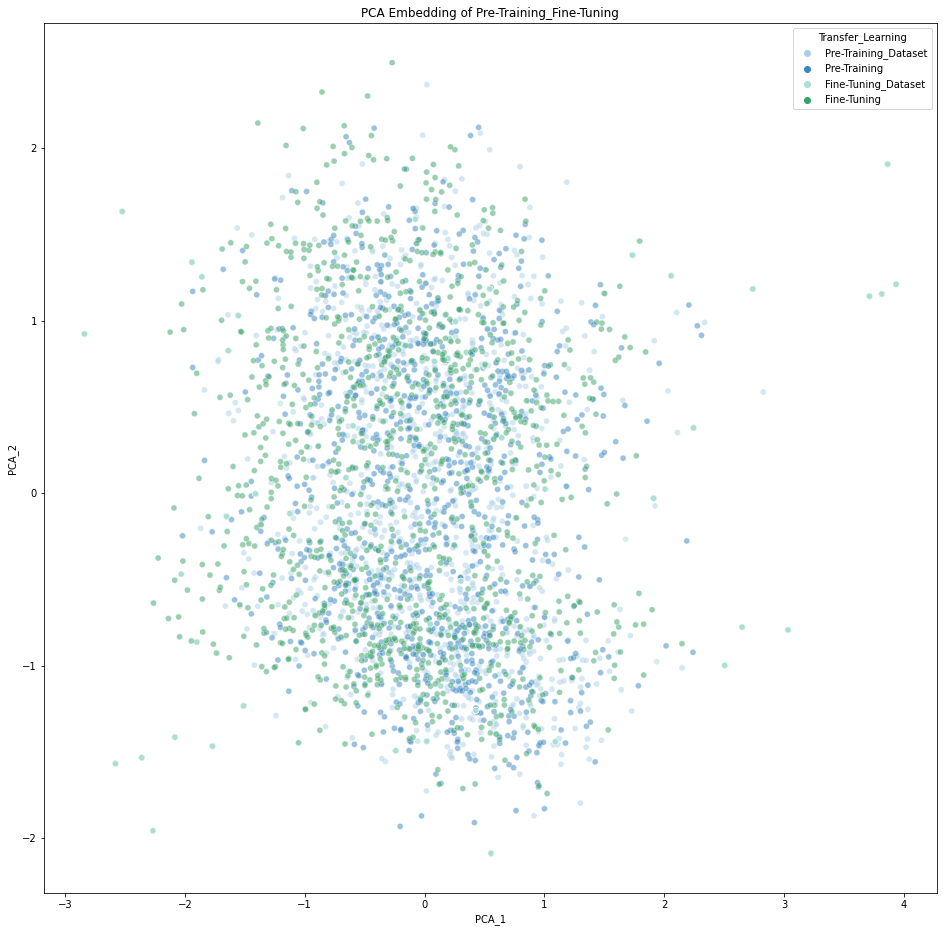

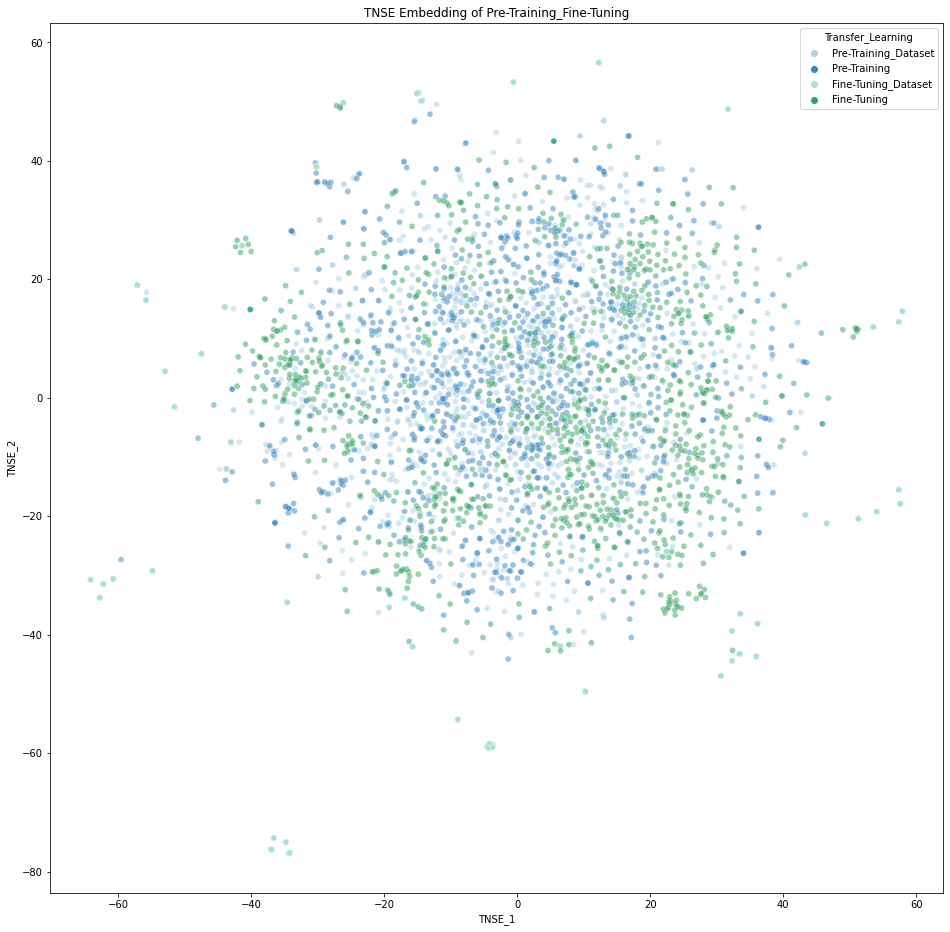

In [ ]:
#palette = sns.color_palette(["hotpink", "dodgerblue"])
for method in ["UMAP", "PCA", "TNSE"]: # 
    plt.figure(figsize=(16,16))
    sns.scatterplot(data=bbbp,
                    x=f"{method}_1",
                    y=f"{method}_2",
                    hue = hue_parameter,
                    alpha = 0.5,
                    palette = palette)
    plt.title(f"{method} Embedding of Pre-Training_Fine-Tuning")
    #plt.savefig(f'/content/gdrive/MyDrive/추가 자료/딥러닝을 이용한 신약개발/논문 작성/리뷰어 코멘트/Fine_Tuning Dataset Visualization UMAP/Results/{method}_Pre-Training_Fine-Tuning.png')
    plt.show()

# Embed Fine-Tuning Results in Global Chemical Space Approximation (Dataset-Agnostic Embedding)

### Read in and process ChEMBL data
_Note: We want this walk-through to be fully reproducible with publicly available data. Since the dataset we used at Reverie create our internal Dataset-Agnostic Embedding can't be shared here, instead we select a random sample of ChEMBL compounds as our approximation of global chemical space._

In [ ]:

# Read in data from MoleculeNet
chembl = pd.read_csv("https://deepchemdata.s3-us-west-1.amazonaws.com/datasets/chembl_sparse.csv.gz", compression='gzip')

# Sample a random 10k
chembl_sample = chembl.sample(n=10000)


### Compute ECFP descriptors

In [ ]:
bbbp_Fine.shape

(1090, 1)

In [ ]:
test_sample = bbbp_Fine

In [ ]:
%%time
# Compute desrciptors and keep track of which failed to featurize
test_descriptors, test_keep_idx = compute_ecfp_descriptors(bbbp_Fine["smiles"])

# Only keep those that sucessfully featurized
test_sample = test_sample.iloc[test_keep_idx]

CPU times: user 1.78 s, sys: 6.56 ms, total: 1.79 s
Wall time: 2.29 s


In [ ]:

%%time
# Compute desrciptors and keep track of which failed to featurize
chembl_ecfp_descriptors, chembl_keep_idx = compute_ecfp_descriptors(chembl_sample["smiles"])

# Only keep those that sucessfully featurized
chembl_sample = chembl_sample.iloc[chembl_keep_idx]


CPU times: user 20.5 s, sys: 203 ms, total: 20.7 s
Wall time: 22.1 s


### Embed 'global' sample with UMAP to create Dataset-Agnostic model

In [ ]:
%%time
umap_model_global = umap.UMAP(metric = "jaccard",
                               n_neighbors = 25,
                               n_components = 2,
                               low_memory = False,
                               min_dist = 0.001)
X_umap_global = umap_model_global.fit_transform(chembl_ecfp_descriptors)
chembl_sample["UMAP_1"], chembl_sample["UMAP_2"] = X_umap_global[:,0], X_umap_global[:,1]

/usr/local/lib/python3.8/dist-packages/umap/umap_.py:1802: UserWarning: gradient function is not yet implemented for jaccard distance metric; inverse_transform will be unavailable
  warn(


CPU times: user 1min 20s, sys: 758 ms, total: 1min 21s
Wall time: 1min 15s


### Use Dataset-Agnostic UMAP model to embed Fine-Tuning Results

In [ ]:
%%time
X_umap_bbbp = umap_model_global.transform(test_descriptors)  # ecfp_descriptors
test_sample["UMAP_1 (global)"], test_sample["UMAP_2 (global)"] = X_umap_bbbp[:,0], X_umap_bbbp[:,1]

CPU times: user 34.9 s, sys: 214 ms, total: 35.1 s
Wall time: 36.5 s


<timed exec>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### Fit HDBScan clustering model on 'global' data & use to cluster Fine-Tuning Results

In [ ]:
# Define HDBSCAN model
hdbscan_model = hdbscan.HDBSCAN(
        min_cluster_size=10,
        min_samples=10,
        prediction_data=True,
        cluster_selection_method="eom")

# Fit and predict on ChEMBL-sample
chembl_sample["global_cluster"] = hdbscan_model.fit_predict(X_umap_global)

# Use ChEMBL-sample HDBSCAN model to cluster BBBP data
test_sample["global_cluster"], _ = hdbscan.approximate_predict(hdbscan_model, np.nan_to_num(X_umap_bbbp, nan=0))

<ipython-input-18-1125d070cea5>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sample["global_cluster"], _ = hdbscan.approximate_predict(hdbscan_model, np.nan_to_num(X_umap_bbbp, nan=0))


### Visualize Dataset-Agnostic Fine-Tuning Results Embedding and Global Chemical Space Approximation (colored by global cluster)
* Because this is a soft clustering, some compounds don't end up getting assigned a cluster (their cluster value = 0)
* These compounds that do not end up in clusters are colored gray in these depictions
* With a larger 'global approximation' dataset than this 10k sample you are likely to have more compounds in the BBBP dataset that are represented by global clusters

In [ ]:
# Determine axes limits to put plots on the same scale
buffer_space = 0.5 # Extra space around the edges
x_lim = chembl_sample["UMAP_1"].min()-buffer_space, chembl_sample["UMAP_1"].max()+buffer_space
y_lim = chembl_sample["UMAP_2"].min()-buffer_space, chembl_sample["UMAP_2"].max()+buffer_space

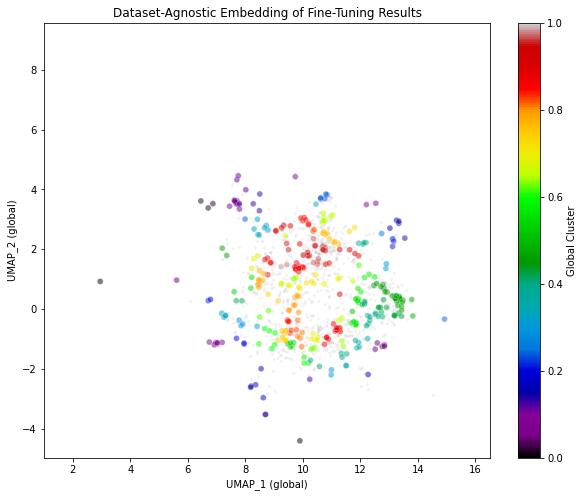

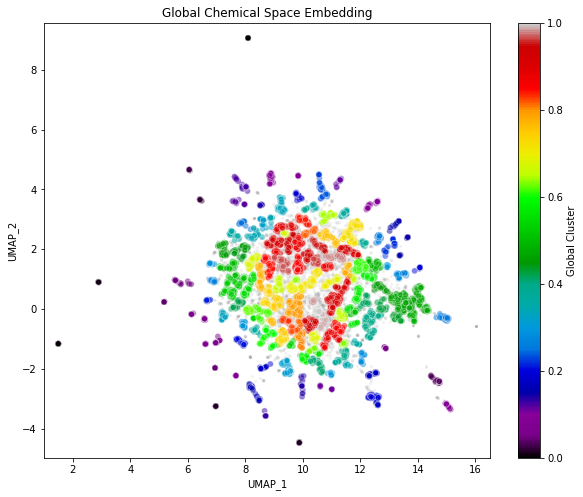

In [ ]:
plot_global_embeddings_with_clusters(test_sample,
                      x_col="UMAP_1 (global)",
                      y_col="UMAP_2 (global)",
                      x_lim=x_lim,
                      y_lim=y_lim,
                      cluster_col="global_cluster",
                      title="Dataset-Agnostic Embedding of Fine-Tuning Results")

plot_global_embeddings_with_clusters(chembl_sample,
                      x_col="UMAP_1",
                      y_col="UMAP_2",
                      x_lim=x_lim,
                      y_lim=y_lim,
                      cluster_col="global_cluster",
                      title="Global Chemical Space Embedding")